In [153]:

import numpy as np

#from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
#Base do scikit-learn com dados reais não sintética 


def criaDatasetBidimensionalMulticlasse(n_classes=3):
    """
    Cria um dataset bidimensional multiclasse.
    """
    #X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0, 1.0), cluster_std=0.02)
    #X, y = load_iris(return_X_y = True)
    iris = datasets.load_iris(centers=n_classes, center_box=(0, 1.0), cluster_std=0.02)
    X = iris.data[:, :2]  # Somente as primeiras duas features
    y = iris.target
    return X, y


#n_classes = 4
#X, y = criaDatasetBidimensionalMulticlasse(1000, n_classes)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3)

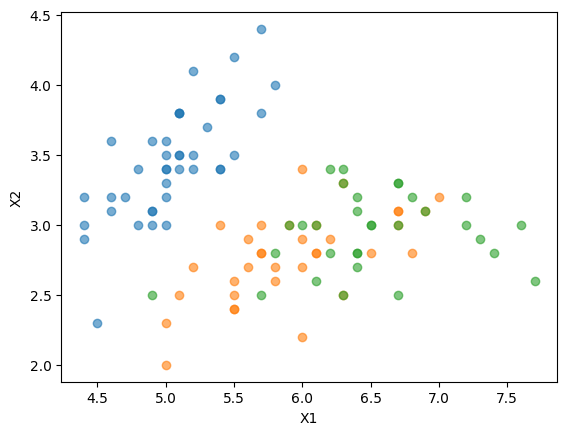

In [154]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:, 0][y==k],X[:, 1][y==k], "o", alpha=0.6)

plotaDatasetBidimensional(Xtr, ytr)

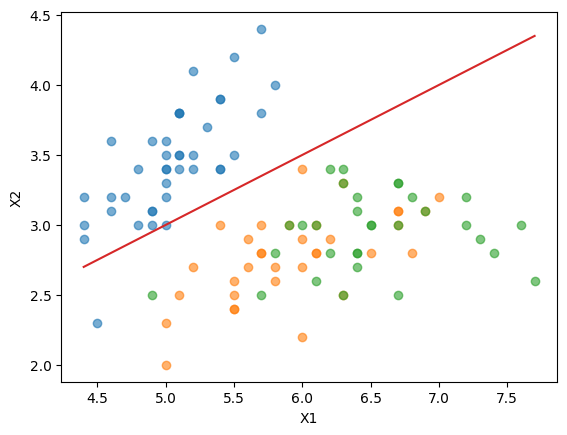

In [155]:
def plotaHiperplanoDatasetBidimensional(X, vetor, intercept=0):
    """
    Plota um definido por um
    vetor e o valor em que este vetor 
    intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, 2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array([1, 2]) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, vetor_hyperplano, 1)

In [156]:
def sign(a):
    return (a >= 0) * 2 - 1

def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [157]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [158]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05, 
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

0.7619047619047619
[[ 10.91738523   3.48541895 -21.8441114 ]
 [-38.93472172  37.15845059  44.15929909]
 [ 65.68402104 -66.50151792 -71.89924826]]


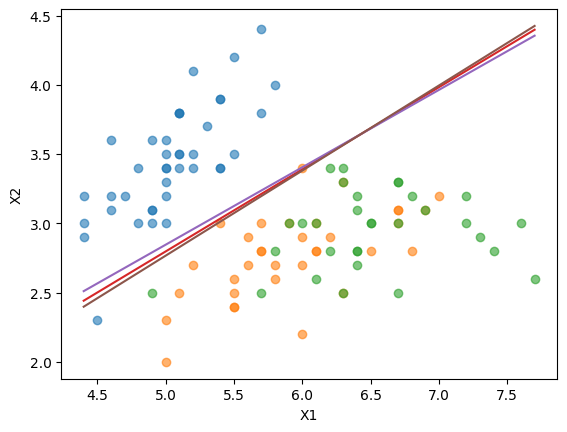

In [163]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)

if perceptron.w.shape[1] == 1:
  plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
else:
  for i in range(perceptron.w.shape[1]):
    plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-157-a317e16988ee>:14: RuntimeWarning: overflow encountered in square
  return np.sum((1 - (y * ypred))**2)


0.3238095238095238 0.35555555555555557
[[-7.78321169e+164 -1.16923985e+164 -3.65071129e+164]
 [-4.54602325e+165 -6.82930358e+164 -2.13230978e+165]
 [-2.40489254e+165 -3.61277106e+164 -1.12801357e+165]]


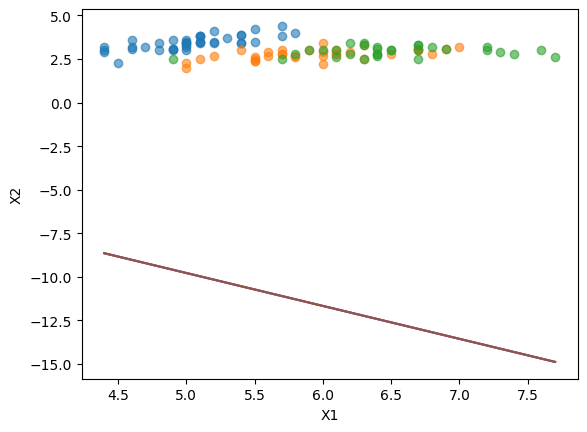

0.6666666666666666 0.6444444444444445
[[  0.45884619   0.13789026  -4.95476253]
 [ -5.24221365   3.46439008   8.89308049]
 [  9.05473481 -15.28480266 -14.27874182]]


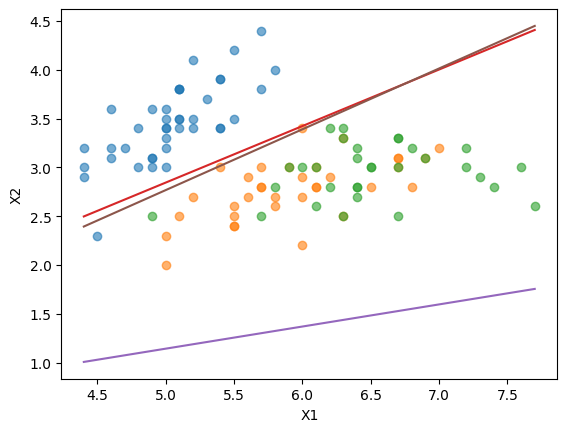

0.7714285714285715 0.8222222222222222
[[ 0.50011859  0.99317647 -1.50958176]
 [-4.68929236  3.83664725  4.62679643]
 [ 8.04412219 -6.87953183 -7.6976303 ]]


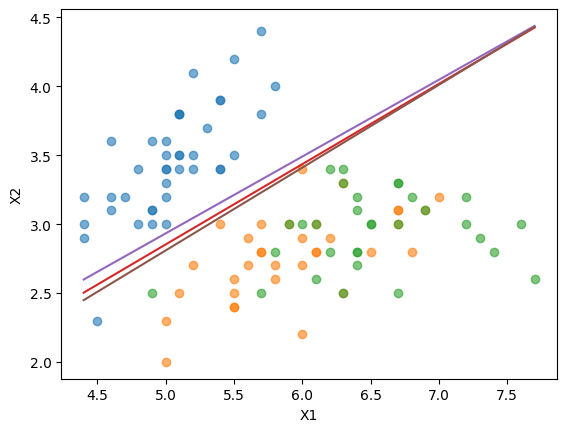

0.6952380952380952 0.5777777777777777
[[  1.84425742  -0.06770458  -5.29530162]
 [ -7.52297218   7.3637686    5.07831406]
 [ 12.58534094 -12.77184905 -16.463915  ]]


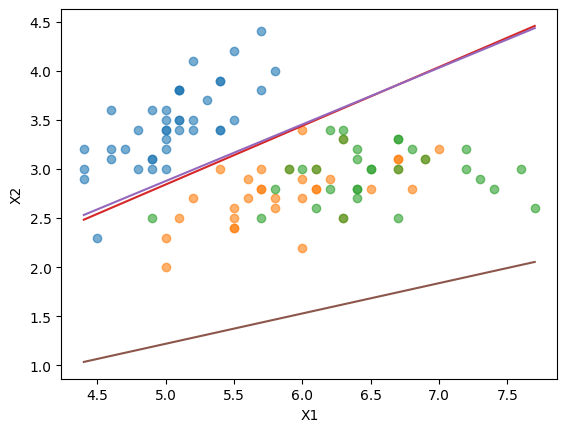

In [162]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    perceptron = Perceptron(training_algorithm=DescidaGradiente(learning_rate=0.01, regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)))
    print(perceptron.w)
    plotaDatasetBidimensional(Xtr, ytr)
    if perceptron.w.shape[1] == 1:
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
    else:
        for i in range(perceptron.w.shape[1]):
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])
    plt.show()